In [89]:
import os 
from dotenv import load_dotenv
from typing import TypedDict, List, Sequence, Literal
from pydantic import BaseModel, Field

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langgraph.graph import StateGraph, START, END 
from langgraph.graph.message import BaseMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [90]:
groq_api_key = os.getenv('GROQ_API_KEY')
llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [91]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [92]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]

doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = text_splitter.split_documents(doc_list)

vectordb = Chroma.from_documents(
    documents=documents,
    collection_name="rag-db",
    embedding=embeddings
)

retriever = vectordb.as_retriever()

In [93]:
retriever.get_relevant_documents("agent memory")

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the qua

In [94]:
retrieve_tool = create_retriever_tool(
    retriever,
    name="retrieve_rag_tool",
    description="Search and retrun information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs. You are a specialized assistant. \
        Use the 'retriever_tool' **only** when the query explicitly related to Langchain blog data. For all other queries, respond directly without using any tool.\
            For any simple quieries 'hi', 'hello', or 'how are you', provide a normal response."
)

In [95]:
llm_with_tool = llm.bind_tools([retrieve_tool])

#### RAG-Chain

In [96]:
template = """ 
You are a helpful assistant tasked with question-answering. Provide the answer based on provided context only.
context: {context}
question: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

rag_chain = prompt | llm

#### Retriever grade

In [97]:
class GradeDocument(BaseModel):
    binary_score: str = Field(description="Check the relevancy of the document with question 'yes' or 'no'")

In [98]:
structured_llm_op = llm.with_structured_output(GradeDocument)

template = """You are a ai assistant grader, check the given documents are relevant to the question or not. If the key word or semantic meaning are matching \
    consider it as relevant. Provide the answer in 'yes' or 'no'\
        content: {documents} 
        question: {question}
        """

grader_prompt = PromptTemplate(
    template=template,
    input_variables=["documents", "question"]
)

retriever_grade = grader_prompt | structured_llm_op

#### Hallucination Grader

In [99]:
class GradeHallucination(BaseModel):
    binary_score: str = Field(description="Generated answer is relevancy 'yes' or 'no'")

In [100]:
structured_llm_halu_op = llm.with_structured_output(GradeHallucination)

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a grader checking if an LLM generation is grounded in or supported by retrieved facts. Give a simple answer 'yes' or 'no'"),
        ("user", "generation: {generation}, facts:{documents}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_halu_op

In [101]:
#### Answer grader

In [102]:
class GradeAnswer(BaseModel):
    binary_score: str = Field(description="Answer addresses question, 'yes' or 'no'")
    

structured_ans_grader = llm.with_structured_output(GradeAnswer)

system = """ 
You are an helpful ai assistant tasked with identify provided answer is relevens to the question. 
Give a binary score 'yes' or 'no'
"""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("user", ("user question: {question}, \n\ngeneration:{generation}"))
    ]
)

answer_grader = answer_prompt | structured_ans_grader

#### Question Re-Writer

In [103]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("user", """Here is the initial question: \n\n{question} \n
         Here is the document: \n\n{documents}
         Formulate an improved question. if possible other return 'question not relevant'.""")
    ]
)

question_reqriter = re_write_prompt | llm | StrOutputParser()

In [104]:
class AgentState(TypedDict):
    question: str
    generation: str 
    documents: List[str]
    filtered_docs: List[str]
    unfiltered_docs: List[str]

In [105]:
def retrieve(state: AgentState):
    print("---RETRIEVE---")
    question = state['question']
    
    documents = retriever.get_relevant_documents(question)
    return{"documents": documents, "question": question}

In [106]:
def grade_documents(state: AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_documents = []
    unfiltered_documents = []
    
    for doc in documents:
        score = retriever_grade.invoke({"question": question, "documents": doc})
        grade = score.binary_score
    
        if grade == 'yes':
            print("---GRADE: DOCUMENTS RELEVANT---")
            filtered_documents.append(documents)
        else:
            print("---GRADE: dOCUMENTS NOT RELEVANT---")
            unfiltered_documents.append(documents)
            
    if len(unfiltered_documents) > 1:
        return{"unfiltered_docs": unfiltered_documents, "filtered_docs": [], "question": question}
    else:
        return{"filtered_docs": filtered_documents, "unfiltered_docs": [], "question": question}
        

In [107]:
def decide_to_generate(state: AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    filtered_docs = state['filtered_docs']
    unfiltered_docs = state['unfiltered_docs']
    
    if unfiltered_docs:
        print("---ALL THE DOCUMENTS ARE NOTE RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    if filtered_docs:
        print("---DECISION: GENERATE---")
        return "generate"

In [108]:
def generate(state: AgentState):
    print("---GENERATE---")
    question = state['question']
    documents = state['documents']
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": "question", "generation": generation}

In [109]:
def transform_query(state: AgentState):
    question = state['question']
    documents = state['documents']
    
    response = question_reqriter.invoke({"question": question, "documents": documents})
    print(f"---RESPONSE---{response}")
    
    if response == "question not relevant":
        print("---QUESTION IS NOT AT ALL RELEVANT---")
        return {"documents": documents, "question": question, "generation": "question was not at all relevant"}
    else:
        return {"documents": documents, "question": response}

In [110]:
def decide_to_generate_after_transformation(state: AgentState):
    question = state['question']
    
    if question == "question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [111]:
from pprint import pprint

def grade_generation_vs_documents_and_question(state: AgentState):
    print("---CHECK HELLUCINATIONS---")
    question = state['question']
    documents = state['documents']
    generation = state['generation']
    
    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score.binary_score 
    
    if grade == 'yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS")
        print("---GRADE GENERATION vs QUESTION---")
        
        score = answer_grader.invoke({"question": question, "generation": generation})
        
        grade = score.binary_score 
        
        if grade == 'yes':
            print("---DECISION: GENERATION ADDRESS THE QUESITON")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
        
    else:
        ppinrt("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        return "not useful"

#### From here langgraph workflow will start

In [112]:
workflow = StateGraph(AgentState)

workflow.add_node("Docs_Vector_Retriever", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents)
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

workflow.add_edge(START, "Docs_Vector_Retriever")
workflow.add_edge("Docs_Vector_Retriever", "Grading_Generated_Documents")

workflow.add_conditional_edges(
    "Grading_Generated_Documents",
    decide_to_generate,
    {
        "generate": "Content_Generator",
        "transform_query": "Transform_User_Query"
    }
)

workflow.add_conditional_edges(
    "Content_Generator",
    grade_generation_vs_documents_and_question,
    {
        "useful": END,
        "not useful": "Transform_User_Query"
    }
)

workflow.add_conditional_edges(
    "Transform_User_Query",
    decide_to_generate_after_transformation,
    {
        "Retriever": "Docs_Vector_Retriever",
        "query_not_at_all_relevant": END
    }
)

In [113]:
app = workflow.compile()

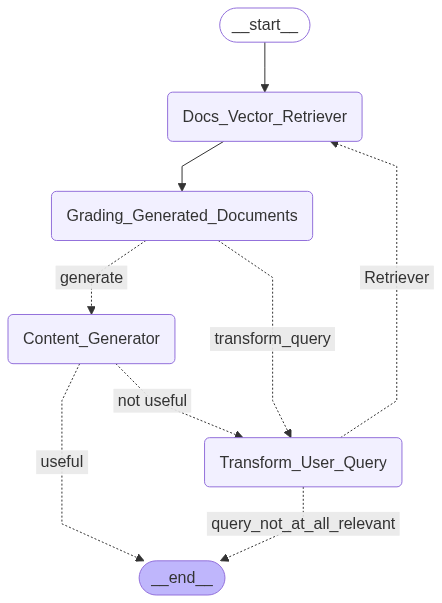

In [114]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [115]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [116]:

app.invoke(inputs)["generation"]

---RETRIEVE---
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
---GRADE: DOCUMENTS RELEVANT---
---GRADE: DOCUMENTS RELEVANT---
---GRADE: DOCUMENTS RELEVANT---
---GRADE: DOCUMENTS RELEVANT---
----ACCESS GRADED DOCUMENTS----
---DECISION: GENERATE---
---GENERATE---
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESS THE QUESITON


AIMessage(content='In a LLM-powered autonomous agent system, there are two types of agent memory: short-term memory and long-term memory.\n\n1. **Short-term memory**: This type of memory is utilized through in-context learning, also known as Prompt Engineering. It allows the model to learn from the input it receives and make decisions based on that information.\n\n2. **Long-term memory**: This provides the agent with the capability to retain and recall information over extended periods. It often leverages an external vector store and fast retrieval, enabling the agent to store and retrieve large amounts of information. This allows the agent to remember past experiences, learn from mistakes, and improve its performance over time.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 1783, 'total_tokens': 1919, 'completion_time': 0.494545455, 'prompt_time': 0.099134482, 'queue_time': 0.063633729, 'total_time': 0.593679937}, 'model_name': 'l